In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
data_m=50                    #每个节点数据集的个数
N = 3                        #x的维数
n = NETWORK_SIZE = 100     #节点的个数
xi=np.array([0,0.5,1])       #vim用到的x值，是固定的.
PROBABILITY_OF_EAGE = 0.5   #随机图的概率参数

In [3]:
###改进
###生成系数数据 uim，data_uim是一个列表，列表中每一个元素是一个50*3的矩阵。
data_uim = []
i=j=k=0
for i in range(n):
    np.random.seed(i) #注意添加np.，否则seed可能无效。
    uim=np.random.normal(0,20,size=(data_m,N))#生成一个50*3的多位数组，均值为0，标准差为20。
    uim[:,N-1]=1#将第三列改为1，论文设定。
    data_uim.append(uim)
###生成数据 cim，data_cim是一个列表，列表中每一个元素是一个1*50的矩阵。
data_cim=[]
for k in range(n):
    np.random.seed(n+k)
    cim=np.random.normal(0,10,size=(1,data_m))
    data_cim.append(cim)
###生成数据 vim，data_vim是一个列表，列表中每一个元素是一个1*50的矩阵。
data_vim=[]
for j in range(n):
    vim = np.dot(xi,np.transpose(data_uim[j]))#+data_cim[j]#target
    data_vim.append(vim)

In [4]:
#定义集中式的损失函数1，将每个节点的loss值相加，返回的是一个值。
#改进的想法：和分布式相统一，将x设为100*3的。
def loss_1(x):
    data_loss = []
    i=0
    aloss=0
    for i in range(n):
        loss=1/data_m*(np.dot(x,np.transpose(data_uim[i]))-data_vim[i])**2
        loss=sum(loss)#第一个sum将loss由多维数组降成一维数组。
        loss=sum(loss)#第二个sum一维数组各元素相加。
        data_loss.append(loss)
    aloss=sum(data_loss)
    return aloss

In [5]:
#定义集中式的梯度函数1，返回的是一个1*3的矩阵。
#改进的想法：和分布式相统一，将x设为100*3的。
def grad_1(x):
    data_grad=[]
    for i in range(n):
        grad=2/data_m*np.dot((np.dot(x,np.transpose(data_uim[i]))-data_vim[i]),data_uim[i])
        data_grad.append(grad)
    data_grad=sum(data_grad)#行相加。
    data_grad=data_grad[0]#从多维数组中取值。
    return data_grad

In [6]:
def generateRandomNetwork():
    # 生成邻接矩阵
    count = 0
    for i in range(NETWORK_SIZE):
        for j in range(i + 1, NETWORK_SIZE):
            probability = random.random()   # 生成0-1之间的数值
            if probability < PROBABILITY_OF_EAGE:
                count = count + 1
                MAT_Adjacent[i][j] = MAT_Adjacent[j][i] = 1
    print('您所构造的ER网络边数为：' + str(count))

    # 生成度矩阵，并验证算法是否正确
    degree = MAT_Adjacent.sum(axis=0)  # 计算lie和，degree用于存放每个节点的度
    for i in range(NETWORK_SIZE):  # 计算度矩阵
        MAT_Degree[i][i] += degree[i]
    average_degree = degree.sum() / NETWORK_SIZE
    print('平均度为' + str(average_degree))  # 计算平均度，所有节点度的和除以节点数
    
    identify = 0.0
    statistic = np.zeros((NETWORK_SIZE), dtype=float)  # statistic将用于存放度分布的数组，数组下标为度的大小，对应数组内容为该度的概率
    for i in range(NETWORK_SIZE):
        statistic[degree[i]] = statistic[degree[i]] + 1
    for i in range(NETWORK_SIZE):
        statistic[i] = statistic[i] / NETWORK_SIZE
        identify = identify + statistic[i]
    identify = int(identify)  # 取整
    print('如果output为1则该算法正确\toutput=' + str(identify))  # 用于测试算法是否正确

    # 生成网络双随机权重矩阵，基于拉普拉斯方法
    degree_max = 0
    for i in range(NETWORK_SIZE):
        if degree_max < MAT_Degree[i][i]:
            degree_max = MAT_Degree[i][i]
    Alpha = 1 / degree_max
    for i in range(NETWORK_SIZE):
        for j in range(NETWORK_SIZE):
            if (i == j):
                MAT_EdegWight[i][j] = 1 - MAT_Degree[i][i] * Alpha
            elif (MAT_Adjacent[i][j] == 1):
                MAT_EdegWight[i][j] = Alpha

# 将ER网络写入文件中
def writeRandomNetworkToFile():
    ARRS = []  # 创建字典型变量，用于之后检测问题
    f = open('randomNetwork.txt', 'w+')  # 用写的方式打开本地文件，若文件不存在，则自动建立新文件

    f.write('The adjacent matrix is:\n')
    blank_num = 2  # 规范化输出
    t = NETWORK_SIZE
    while (t >= 10):
        t /= 10
        blank_num += 1
    num_end_position = 1
    for i in range(NETWORK_SIZE):
        f.write(str(i + 1))
        if (i+1)%(10**num_end_position) == 0:
            num_end_position += 1
        for j in range(blank_num+1-num_end_position):
            f.write(' ')
        t = MAT_Adjacent[i]  # 邻接矩阵对应数值
        ARRS.append(t)
        for j in range(NETWORK_SIZE):
            s = str(t[j])  # 强制转换成字符串形式
            f.write(s)
            f.write(' ')
        f.write('\n')  # 一行结束，进行下一行填写

    # f = open('randomNetwork.txt', 'w+')  # 将度分布写入文件名为degree01文件中，若磁盘中无此文件将自动新建
    f.write('\nThe degree matrix is:\n')
    blank_num = 2  # 规范化输出
    t = NETWORK_SIZE
    while (t >= 10):
        t /= 10
        blank_num += 1

    ARRS = []
    num_end_position = 1
    for i in range(NETWORK_SIZE):
        f.write(str(i + 1))
        if (i + 1) % (10 ** num_end_position) == 0:
            num_end_position += 1
        for j in range(blank_num + 1 - num_end_position):
            f.write(' ')
        t = MAT_Degree[i]  # 邻接矩阵对应数值
        ARRS.append(t)
        for k in range(NETWORK_SIZE):
            s = str(t[k])  # 强制转换成字符串形式
            f.write(s)
            f.write(' ')
        f.write('\n')  # 一行结束，进行下一行填写
    num_end_position = 1

    f.write('\nThe distribution probability of degree is:\n')
    degree = MAT_Adjacent.sum(axis=1)  # 计算行和，degree用于存放每个节点的度
    statistic = np.zeros((NETWORK_SIZE), dtype=float)  # statistic将用于存放度分布的数组，数组下标为度的大小，对应数组内容为该度的概率
    for i in range(NETWORK_SIZE):
        statistic[degree[i]] = statistic[degree[i]] + 1
    for i in range(NETWORK_SIZE):
        statistic[i] = statistic[i] / NETWORK_SIZE
    for i in range(NETWORK_SIZE):
        f.write(str(i + 1))
        if (i + 1) % (10 ** num_end_position) == 0:
            num_end_position += 1
        for j in range(blank_num + 1 - num_end_position):
            f.write(' ')
        s = str(statistic[i])  # 注意写入操作要求是字符串格式，因此用str进行格式转换
        f.write(str(s))  # 写入的每一行由两部分组成，一个元素为度的下标，第二个元素为度的概率
        f.write('\n')  # 每个节点的度及概率写入完成将进行换行，输入下一个节点的度及度分布
    f.close()

# 用于绘制ER图
def showGraph():
    G = nx.Graph()
    nodes = np.array(range(NETWORK_SIZE))
    G.add_nodes_from(nodes)
    for i in range(len(MAT_Adjacent)):
        for j in range(len(MAT_Adjacent)):
            if MAT_Adjacent[i][j] == 1:  # 如果不加这句将生成完全图，ER网络的邻接矩阵将不其作用
                G.add_edge(i, j)
    position = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, position, nodelist=nodes, node_color="r")
    nx.draw_networkx_edges(G, position)
    nx.draw_networkx_labels(G, position)
    plt.show()

您所构造的ER网络边数为：2456
平均度为49.12
如果output为1则该算法正确	output=1


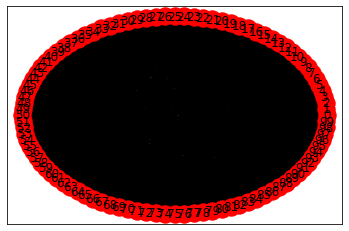

In [7]:
MAT_Adjacent = np.zeros((NETWORK_SIZE, NETWORK_SIZE), dtype=int)  # 初始化邻接矩阵
MAT_Degree = np.zeros((NETWORK_SIZE, NETWORK_SIZE), dtype=int)  # 初始化度矩阵
MAT_Laplacian = np.zeros((NETWORK_SIZE, NETWORK_SIZE), dtype=int)  # 初始化拉普拉斯矩阵（不一定用到）
MAT_EdegWight = np.zeros((NETWORK_SIZE, NETWORK_SIZE), dtype=float)  # 初始化边权重阵

generateRandomNetwork()  # 生成ER随机网络
writeRandomNetworkToFile()  # 将随机网络写入randomNetwork.txt文件中
showGraph()
W=MAT_EdegWight

In [8]:
#分布式的损失函数1
def loss_2(x):
    data_loss=np.zeros(n)#定义为数组而不是列表会减少很多麻烦
    i=0
    DNGD_loss=0
    for i in range(n):
        loss=1/data_m*(np.dot(x[i,:],np.transpose(data_uim[i]))-data_vim[i])**2
        loss=sum(loss)
        #loss=sum(loss)
        data_loss[i]=loss
    DNGD_loss=sum(data_loss)
    return DNGD_loss

In [9]:
#分布式的梯度函数1
def grad_2(x):
    x=np.array(x)
    data_grad=np.zeros((n,N))#定义为数组而不是列表会减少很多麻烦
    i=0
    for i in range(n):
        uim=data_uim[i]
        grad=2/data_m*np.dot((np.dot(x[i,:],np.transpose(uim))-data_vim[i]),uim)
        data_grad[i,:]=grad
    return data_grad

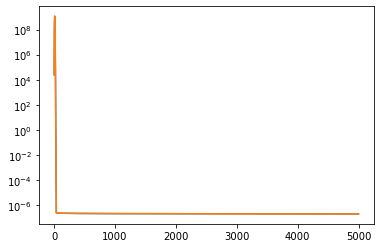

[2.32482917e-07 5.00000109e-01 1.00045066e+00]
最后一次迭代的梯度为 [4.85056809e-05 1.82392883e-05 9.01127551e-02]
利用算法得到的最低loss为 2.0303378630140636e-07


In [10]:
###算法1，使用邻居状态
if __name__ == '__main__':
    iter=5000
    x=np.ones((n,N)) 
    a1=0.009
    loss=0
    grad=0
    plt_loss_1=[]
    for i in range(iter):
        a=a1/(i+1)
        grad=grad_2(x)
        x=np.dot(W,x)-a*grad
        loss=loss_2(x)
        loss=loss/n
        plt_loss_1.append(loss)
    algorithm_1_loss=loss
    plt.plot(range(iter),np.array(plt_loss_1))
    plt.plot(range(iter),np.array(plt_loss_1))#默认98.2434为最优值。f-f*,f*默认为GD算法的最小loss
    plt.yscale('log')
    plt.show()
    print(x[1,:])
    print('最后一次迭代的梯度为',sum(grad))
    print('利用算法得到的最低loss为',algorithm_1_loss)

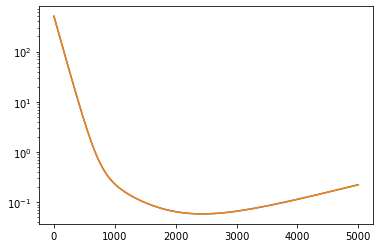

[-0.00669249  0.49632447  0.99959773]
最后一次迭代的梯度为 [ 9.90399744  3.6795477  -0.40165251]
利用算法得到的最低loss为 0.22343071618496446


In [11]:
#算法2，使用邻居梯度
if __name__ == '__main__':
    iter=5000
    x=np.ones((n,N)) 
    beta=0.000006
    loss=0
    grad=0
    plt_loss_2=[]
    for i in range(iter):
        grad=grad_2(x)
        x=x-beta*np.dot(W,grad)
        loss=loss_2(x)
        loss=loss/n
        plt_loss_2.append(loss)
    algorithm_2_loss=loss
    plt.plot(range(iter),np.array(plt_loss_2))
    plt.plot(range(iter),np.array(plt_loss_2))#f-f*,f*默认为GD算法的最小loss
    plt.yscale('log')
    plt.show()
    print(x[1,:])
    print('最后一次迭代的梯度为',sum(grad))
    print('利用算法得到的最低loss为',algorithm_2_loss)

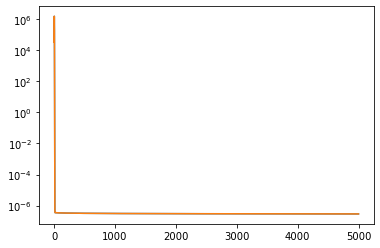

[2.79633500e-07 5.00000130e-01 1.00054246e+00]
最后一次迭代的梯度为 [5.67270424e-05 2.64989239e-05 1.08476314e-01]
利用算法得到的最低loss为 2.941741636377729e-07


In [12]:
#算法3
if __name__ == '__main__':
    iter=5000
    x=np.ones((n,N)) 
    a1=0.01
    loss=0
    grad=0
    plt_loss_3=[]
    for i in range(iter):
        a=a1/(i+1)
        x1=np.dot(W,x)
        grad=grad_2(x1)
        x=x1-a*grad
        loss=loss_2(x)
        loss=loss/n
        plt_loss_3.append(loss)
    algorithm_3_loss=loss
    plt.plot(range(iter),np.array(plt_loss_3))
    plt.plot(range(iter),np.array(plt_loss_3))#f-f*,f*默认为GD算法的最小loss
    plt.yscale('log')
    plt.show()
    print(x[1,:])
    print('最后一次迭代的梯度为',sum(grad))
    print('利用算法得到的最低loss为',algorithm_3_loss)

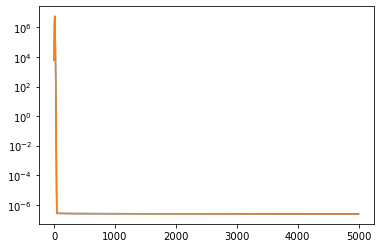

[2.53294608e-07 5.00000125e-01 1.00049029e+00]
最后一次迭代的梯度为 [5.06521676e-05 2.50653965e-05 9.80441998e-02]
利用算法得到的最低loss为 2.403482147135847e-07


In [13]:
#算法4，使用梯度跟踪
if __name__ == '__main__':
    iter=5000
    x=np.ones((n,N))
    grad=grad_2(x)
    d=grad
    a1=0.005
    loss=0
    grad=0
    plt_loss_4=[]
    for i in range(iter):
        a=a1/(i+1)
        grad=grad_2(x)
        x=np.dot(W,x)-a*d
        grad1=grad_2(x)
        d=np.dot(W,d)+grad1-grad
        loss=loss_2(x)
        loss=loss/n
        plt_loss_4.append(loss)
    algorithm_4_loss=loss
    plt.plot(range(iter),np.array(plt_loss_4))
    plt.plot(range(iter),np.array(plt_loss_4))#f-f*,f*默认为GD算法的最小loss
    plt.yscale('log')
    plt.show()
    print(x[1,:])
    print('最后一次迭代的梯度为',sum(grad))
    print('利用算法得到的最低loss为',algorithm_4_loss)

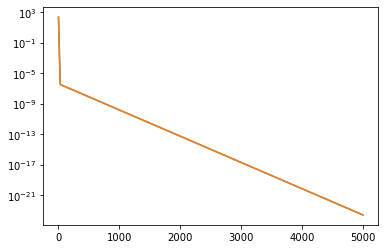

[1.50300651e-15 5.00000000e-01 1.00000000e+00]
最后一次迭代的梯度为 [ 1.65484126e-12 -3.84445580e-12  3.20358677e-10]
利用算法得到的最低loss为 2.5686079295243253e-24


In [14]:
#算法5
if __name__ == '__main__':
    iter=5000
    x=np.ones((n,N)) 
    beta=0.002
    grad=grad_2(x)
    d=grad
    loss=0
    grad=0
    plt_loss_5=[]
    for i in range(iter):
        grad=grad_2(x)
        x=x-beta*np.dot(W,d)
        grad1=grad_2(x)
        d=np.dot(W,d)+grad1-grad
        loss=loss_2(x)
        loss=loss/n
        plt_loss_5.append(loss)
    algorithm_5_loss=loss
    plt.plot(range(iter),np.array(plt_loss_5))
    plt.plot(range(iter),np.array(plt_loss_5))#f-f*,f*默认为GD算法的最小loss
    plt.yscale('log')
    plt.show()
    print(x[1,:])
    print('最后一次迭代的梯度为',sum(grad))
    print('利用算法得到的最低loss为',algorithm_5_loss)

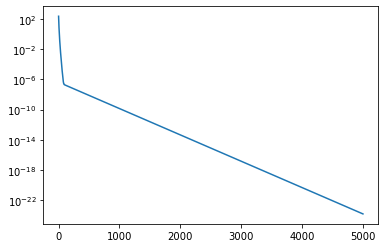

[6.30141405e-16 5.00000000e-01 1.00000000e+00]
最后一次迭代的梯度为 [-1.60920602e-12 -2.34161064e-12  2.55178199e-10]
利用算法得到的最低loss为 1.6148703955644909e-24


In [20]:
#算法6
if __name__ == '__main__':
    iter=5000
    x=np.ones((n,N)) 
    beta=0.002
    grad=grad_2(x)
    d=grad
    loss=0
    grad=0
    plt_loss_6=[]
    for i in range(iter):
        grad=grad_2(x)
        x=np.dot(W,x)-beta*np.dot(W,d)
        grad1=grad_2(x)
        d=np.dot(W,d)+grad1-grad
        loss=loss_2(x)
        loss=loss/n
        plt_loss_6.append(loss)
    algorithm_6_loss=loss
    plt.plot(range(iter),np.array(plt_loss_6))#f-f*,f*默认为GD算法的最小loss
    plt.yscale('log')
    plt.show()
    print(x[1,:])
    print('最后一次迭代的梯度为',sum(grad))
    print('利用算法得到的最低loss为',algorithm_6_loss)

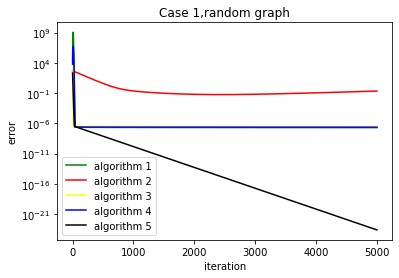

In [16]:
plt.title('Case 1,random graph')
x_axix=np.array(range(iter))
plt.plot(x_axix,np.array(plt_loss_1), color='green', label='algorithm 1')
plt.plot(x_axix,np.array(plt_loss_2), color='red', label='algorithm 2')
plt.plot(x_axix,np.array(plt_loss_3), color='yellow', label='algorithm 3')
plt.plot(x_axix,np.array(plt_loss_4), color='blue', label='algorithm 4')
plt.plot(x_axix,np.array(plt_loss_5), color='black', label='algorithm 5')
plt.legend() # 显示图例
plt.xlabel('iteration')
plt.ylabel('error')
plt.yscale('log')
plt.show()